# Считывание данных и импорт

In [1]:
import pandas as pd
from source import cls
import numpy as np 

In [2]:
user = pd.read_csv('dataset/user.csv')
book = pd.read_csv('dataset/book.csv')

In [3]:
# stem_desc = cls.stemmer(book['Description'])
# book['Stem_Description'] = stem_desc
# book.to_csv('dataset/book.csv', index=False)

In [22]:
print(len(user['ID'].unique()), len(book['Name']))

3822 30470


# Обучение модели word2vec

In [4]:
import gensim
from nltk import word_tokenize
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument, Word2Vec
from gensim.models.word2vec import Word2Vec

def tokenize(text, stopwords, max_len = 20):
    return [token for token in gensim.utils.simple_preprocess(text, max_len=max_len) if token not in stopwords]


In [18]:
# documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(list(book['Stem_Description']))]

documents = [word_tokenize(text) for text in list(book['Stem_Description'])]
# Инициализируйте и обучите модель Doc2Vec
model = Word2Vec(documents, vector_size=100, window=5, min_count=10, workers=4, epochs=20)

### Далее усредняем вектора по докам

In [19]:
# Получение векторов слов из модели Word2Vec
documents_array = []
for doc in documents:
    words_in_document = doc
    word_vectors = []
    for word in words_in_document:
        try:
            word_vectors.append(model.wv[word])
        except KeyError:
            # Если слово отсутствует в модели, игнорируем его или можем использовать среднее значение всех векторов
            continue

    # Усреднение векторов слов
    document_vector = np.mean(word_vectors, axis=0)
    documents_array.append(document_vector)

documents_array = np.array(documents_array)
# document_vector теперь содержит усредненный вектор для всех слов в вашем документе

In [20]:
documents_array.shape

(30470, 100)

In [36]:
doc_dict = dict(zip(book['Name'], documents_array))

In [43]:
# import pickle

# with open('source/Word2Vec_array_29.03.2024.pk1', 'wb') as f:
#     pickle.dump(doc_dict, f)

In [29]:
# np.savetxt('source/Word2Vec_array_29.03.2024.txt', documents_array)

In [26]:
# book['Word2vec'] = documents_array

ValueError: Data must be 1-dimensional

## Визуализация

In [27]:
cls.pca_plotly(documents_array)
pass

In [28]:
model.wv.most_similar("a")

[("'you", 0.6526040434837341),
 ('ha', 0.6474990248680115),
 ("'n", 0.6237877607345581),
 ("'the", 0.6042528748512268),
 ("'to", 0.5914639830589294),
 ("'new", 0.5826696157455444),
 ('obra', 0.5619868040084839),
 ("'what", 0.5610643029212952),
 ('raisin', 0.5440701246261597),
 ('l', 0.5414330959320068)]

### Кластеризация word2vec 

In [29]:
from sklearn.cluster import KMeans

# Определите количество кластеров
k = 5

# Инициализируйте модель KMeans
kmeans = KMeans(n_clusters=k)

# Произведите кластеризацию данных
kmeans.fit(documents_array)

# Получите метки кластеров для каждого образца
labels = kmeans.labels_

# Получите координаты центроидов кластеров
centroids = kmeans.cluster_centers_

cls.pca_plotly(documents_array, labels)
pass

In [34]:
book['Cluster'] = labels

In [38]:
book.to_csv('dataset/book.csv', index=False)

Формально здесь препроцессинг закончен

## Облака слов кластеров

In [11]:
grouped_text = book.groupby('clustering')['Stem_Description'].apply(lambda x: ' '.join(x)).reset_index()
grouped_text

clustering                                   Stem_Description
0           0   classic twentieth-centuri literatur chronicl ...
1           1   one world belov bestsel writer take ultim jou...
2           2   win mean fame fortune.los mean certain death....
3           3   thought safe go back bookstor dougla adam pre...
4           4   go steve lohr chronicl histori softwar earli ...

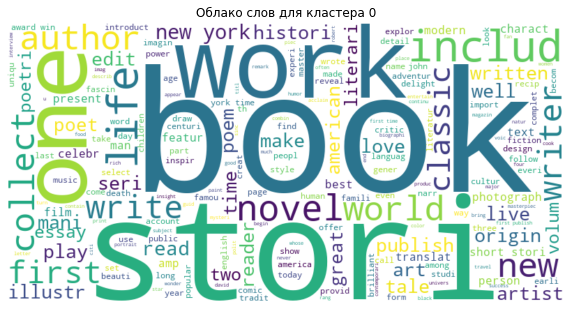

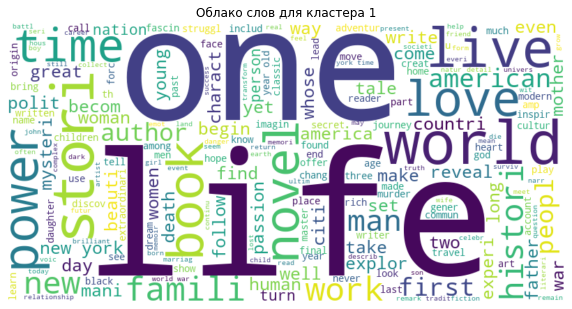

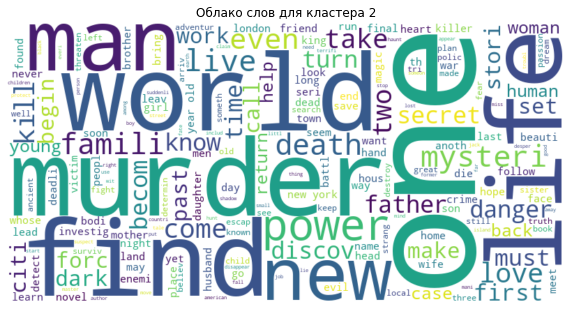

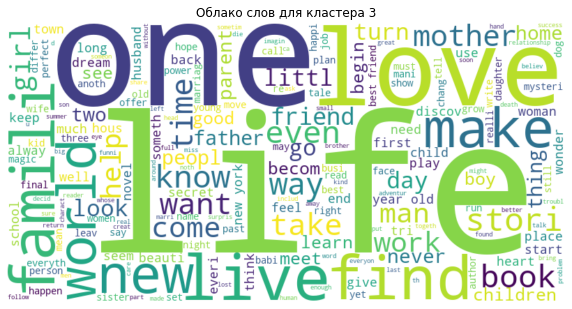

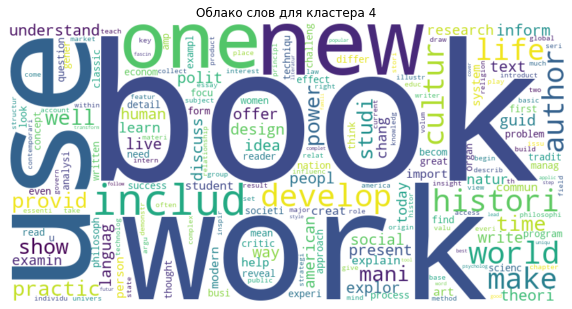

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Создаем объект WordCloud для каждого кластера
for index, row in grouped_text.iterrows():
    cluster = row['clustering']
    text = row['Stem_Description']
    
    # Генерируем облако слов для текста в текущем кластере
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Отображаем облако слов
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Облако слов для кластера {cluster}')
    plt.axis('off')
    plt.show()


## Частота слов в кластерах

In [13]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Создаем словарь для хранения наиболее часто встречающихся слов в каждом кластере
cluster_word_freq = {}

# Проходим по каждой строке DataFrame
for index, row in grouped_text.iterrows():
    cluster = row['clustering']
    text = row['Stem_Description']
    
    # Токенизируем текст
    tokens = word_tokenize(text)
    
    # Создаем объект FreqDist для подсчета частоты слов
    fdist = FreqDist(tokens)
    
    # Получаем наиболее часто встречающиеся слова и их частоту
    top_words = fdist.most_common(20)  # Здесь выбираем 5 наиболее часто встречающихся слов
    
    # Сохраняем результаты в словарь cluster_word_freq
    cluster_word_freq[cluster] = top_words

# Выводим наиболее часто встречающиеся слова для каждого кластера
for cluster, top_words in cluster_word_freq.items():
    print(f"Кластер {cluster}:")
    for word, freq in top_words:
        print(f"Слово: {word}, Частота: {freq}")
    print()


Кластер 0:
Слово: book, Частота: 2788
Слово: stori, Частота: 2036
Слово: new, Частота: 1898
Слово: work, Частота: 1490
Слово: one, Частота: 1429
Слово: first, Частота: 1356
Слово: time, Частота: 1272
Слово: includ, Частота: 1204
Слово: collect, Частота: 1100
Слово: author, Частота: 1085
Слово: world, Частота: 1015
Слово: novel, Частота: 1012
Слово: life, Частота: 999
Слово: edit, Частота: 977
Слово: publish, Частота: 959
Слово: year, Частота: 869
Слово: writer, Частота: 853
Слово: classic, Частота: 836
Слово: •, Частота: 825
Слово: reader, Частота: 803

Кластер 1:
Слово: stori, Частота: 5200
Слово: world, Частота: 4338
Слово: life, Частота: 4300
Слово: one, Частота: 4277
Слово: new, Частота: 3739
Слово: novel, Частота: 3274
Слово: book, Частота: 3035
Слово: time, Частота: 3031
Слово: love, Частота: 2805
Слово: live, Частота: 2784
Слово: year, Частота: 2472
Слово: first, Частота: 2446
Слово: war, Частота: 2424
Слово: american, Частота: 2320
Слово: famili, Частота: 2176
Слово: power, Час

## Профиль пользователя на основе описаний книг

### Строим тренировочную/тестовую выборки

In [77]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(user, test_size=0.2, random_state=12345)
# df_train = df_train.join(book.set_index('Name'), on='Name', how='inner').drop(['Rating', 'Description'], axis=1)
# df_test = df_test.join(book.set_index('Name'), on='Name', how='inner').drop(['Rating', 'Description'], axis=1)

### W2V

In [78]:
id = 1
liked = df_train[(df_train['ID'] == id) & (df_train['Rating_bin'] == 1)]
vec = book[book['Name'].isin(liked['Name'])]['Word2vec']
cls.pca_plotly(list(vec))
liked = df_test[(df_test['ID'] == id) & (df_test['Rating_bin'] == 1)]
vec = book[book['Name'].isin(liked['Name'])]['Word2vec']
cls.pca_plotly(list(vec))
pass

In [79]:
book.head(2)

Name  \
0  The Restaurant at the End of the Universe (Hit...   
1                                         Siddhartha   

                                         Description  \
0  Just when you thought it was safe to go back t...   
1  This classic of twentieth-century literature c...   

                                    Stem_Description  \
0   thought safe go back bookstor dougla adam pre...   
1   classic twentieth-centuri literatur chronicl ...   

                                            Word2vec  clustering  
0  [-0.060236055, 0.39448625, -0.021395477, 0.018...           1  
1  [-0.10898498, -0.122161396, -0.036831837, 0.57...           2

In [80]:
user.head(2)

ID                                               Name           Rating  \
0   1  The Restaurant at the End of the Universe (Hit...   it was amazing   
1  73  The Restaurant at the End of the Universe (Hit...  really liked it   

   Rating_score  Rating_bin  
0             5           1  
1             4           1

In [81]:
id = 1
temp_df = df_train[(df_train['ID'] == id) & (df_train['Rating_bin'] == 1)]

temp_df = temp_df.merge(book, on='Name')
temp_df['clustering'].value_counts().to_dict()

{4: 48, 0: 36, 1: 26, 2: 23, 3: 13}

In [82]:
df_test[(df_test['ID'] == id) & (df_test['Rating_bin'] == 1)].merge(book, on='Name')['clustering'].value_counts().to_dict()

{4: 18, 0: 12, 2: 4, 1: 3, 3: 2}

In [99]:
temp_test = df_test[(df_test['ID'] == id) & (df_test['Rating_bin'] == 1)]

In [109]:
temp_test.merge(book, on='Name')['clustering'].value_counts().to_dict()

{4: 18, 0: 12, 2: 4, 1: 3, 3: 2}

In [83]:
profile = np.mean(temp_df['Word2vec'], axis=0) # ну типа профиль пользователя id 

In [84]:
book['clustering'].value_counts()

clustering
4    8350
0    7014
1    5868
3    4986
2    4252
Name: count, dtype: int64

In [131]:
from scipy.spatial.distance import cosine, euclidean
temp_1 = book[book['clustering'] == 4]
dist = []

for vec in book[book['clustering'] == 4]['Word2vec']:
    dist.append(euclidean(vec, profile))

In [132]:
temp_1['cosine'] = dist

C:\Users\iak7\AppData\Local\Temp\ipykernel_6068\1665342175.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [139]:
temp_1.sort_values('cosine', ascending=True).head(400).merge(temp_test, on='Name')

Name  \
0  The Three Musketeers (The D'Artagnan Romances,...   
1                                    Suite Française   

                                         Description  \
0  We read The Three Musketeers to experience a s...   
1  <b>Suite Française</b> is both a brilliant nov...   

                                    Stem_Description  \
0   read three musket experi sens romanc sheer ex...   
1   suit français brilliant novel wartim extraord...   

                                            Word2vec  clustering    cosine  \
0  [-0.311372, 0.22197895, 0.22737543, 0.3855825,...           4  1.668910   
1  [-0.15695727, 0.22890332, 0.17502435, 0.533408...           4  1.683651   

   ID           Rating  Rating_score  Rating_bin  
0   1   it was amazing             5           1  
1   1  really liked it             4           1

In [140]:
temp_1.shape

(8350, 6)

In [126]:
cosine([0, 1], [1, 0])

1.0

# Классификация

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(profile, y)
print(neigh.predict([[1.1]]))
print(neigh.predict_proba([[0.9]]))

In [53]:
# Пробуем получить реки для мне всех юзеров сразу

for user_id in df_train['ID'].unique():
    liked = df_train[(df_train['ID'] == user_id) & (df_train['Rating_bin'] == 1)]
    
    # дальше понять, как усреднять понравившиеся книги или мб не наадо .... мда треш

In [58]:
df_train[(df_train['ID'] == 1) & (df_train['Rating_bin'] == 1)][['ID', 'Rating_bin']]

ID  Rating_bin
2498    1           1
8781    1           1
17743   1           1
9292    1           1
27482   1           1
...    ..         ...
13415   1           1
24420   1           1
25546   1           1
13516   1           1
23287   1           1

[156 rows x 2 columns]

In [92]:
from sklearn.linear_model import LogisticRegression
X = book[book['Name'].isin(df_train[df_train['ID'] == 1]['Name'])]['Word2vec']
y = df_train[(df_train['ID'] == 1)][['Rating_bin']].values
X = list(X); y = list(y)
clf = LogisticRegression(random_state=0).fit(X, y)
# clf.predict(X[:2, :])
# clf.predict_proba(X[:2, :])
# clf.score(X, y)

c:\Program123\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



### Визуализациия гистограммы интересов одного пользователя

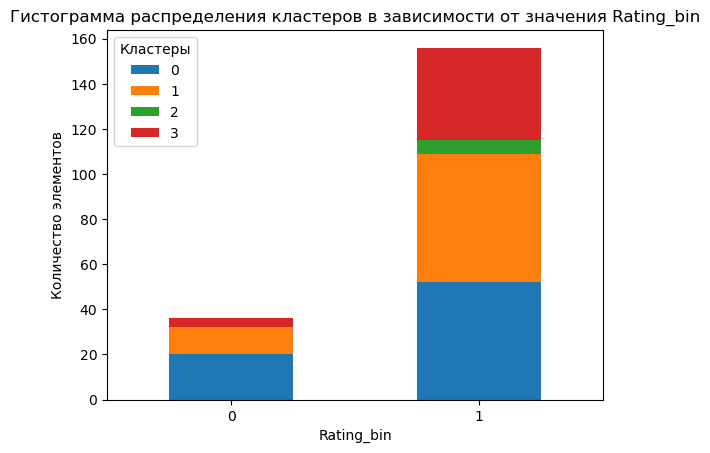

In [25]:
import matplotlib.pyplot as plt

grouped = df_train[df_train['ID'] == 1].groupby('Rating_bin')['clustering'].value_counts().unstack().fillna(0)

# Построить гистограмму
grouped.plot(kind='bar', stacked=True)
plt.xlabel('Rating_bin')
plt.ylabel('Количество элементов')
plt.title('Гистограмма распределения кластеров в зависимости от значения Rating_bin')
plt.xticks(rotation=0)
plt.legend(title='Кластеры')
plt.show()

In [26]:
grouped

clustering     0     1    2     3
Rating_bin                       
0           20.0  12.0  0.0   4.0
1           52.0  57.0  6.0  41.0

## Типа классификация

In [83]:
# from sklearn.linear_model import LinearRegression
# from sklearn import metrics

# model = LinearRegression()
# model.fit(train_tf_idf, df_train[df_train['ID'] == 1]['Rating_score'])

# # Предсказание на тестовой выборке
# y_pred = model.predict(test_tf_idf)

# # Оценка модели
# print('Среднеквадратичная ошибка:', metrics.mean_squared_error(df_test[df_test['ID'] == 1]['Rating_score'], y_pred))

Среднеквадратичная ошибка: 0.8017152308234692
